In [43]:
import gym
import numpy as np

from gym import spaces
from gym.spaces import Box, Discrete, Tuple

class OneHot(gym.Space):
    """
    One-hot space. Used as the observation space.
    """
    def __init__(self, n):
        self.n = n

    def sample(self):
        return np.random.multinomial(1, [1. / self.n] * self.n)
#         return prng.np_random.multinomial(1, [1. / self.n] * self.n)

    def contains(self, x):
        return isinstance(x, np.ndarray) and \
               x.shape == (self.n, ) and \
               np.all(np.logical_or(x == 0, x == 1)) and \
               np.sum(x) == 1

    @property
    def shape(self):
        return (self.n, )

    def __repr__(self):
        return "OneHot(%d)" % self.n

    def __eq__(self, other):
        return self.n == other.n

class IteratedMatchingPennies(gym.Env):
    """
    A two-agent environment for the Matching Pennies game.
    """
    NUM_AGENTS = 2
    NUM_ACTIONS = 2
    NUM_STATES = 5

    def __init__(self, max_steps, batch_size=1):
        self.max_steps = max_steps
        self.batch_size = batch_size
        self.payout_mat = np.array([[1, -1],[-1, 1]])
        self.action_space = Tuple([
            Discrete(self.NUM_ACTIONS) for _ in range(self.NUM_AGENTS)
        ])
        self.observation_space = Tuple([
            OneHot(self.NUM_STATES) for _ in range(self.NUM_AGENTS)
        ])
        self.available_actions = [
            np.ones((batch_size, self.NUM_ACTIONS), dtype=int)
            for _ in range(self.NUM_AGENTS)
        ]

        self.step_count = None

    def reset(self):
        self.step_count = 0
        init_state = np.zeros((self.batch_size, self.NUM_STATES))
        init_state[:, -1] = 1
        observations = [init_state, init_state]
        info = [{'available_actions': aa} for aa in self.available_actions]
        return observations, info

    def step(self, action):
        ac0, ac1 = action

        self.step_count += 1

        rewards = []
        state0 = np.zeros((self.batch_size, self.NUM_STATES))
        state1 = np.zeros((self.batch_size, self.NUM_STATES))
        for i, (a0, a1) in enumerate(zip(ac0, ac1)):
            rewards.append([self.payout_mat[a1][a0], -self.payout_mat[a1][a0]])
            state0[i, a0 * 2 + a1] = 1
            state1[i, a1 * 2 + a0] = 1
        rewards = list(map(np.asarray, zip(*rewards)))
        observations = [state0, state1]

        done = (self.step_count == self.max_steps)
        info = [{'available_actions': aa} for aa in self.available_actions]

        return observations, rewards, done, info

In [41]:
class MatrixGame(gym.Env):
    """An environment consisting of a matrix game with stochastic outomes"""

    NUM_ACTIONS = 3
    NUM_STATES = NUM_ACTIONS ** 2 + 1

    def __init__(
        self,
        payout_mean=np.array([[10, 5, -5], [0, 0, 5], [20, -5, 0]]),
        payout_std=np.array([[0, 0, 0], [0, 0, 0], [0, 20, 20]]),
    ):
        super(MatrixGame, self).__init__()
        self.num_actions = 3
        self.action_space = spaces.Tuple(
            [spaces.Discrete(self.num_actions) for _ in range(2)]
        )
        self.observation_space = spaces.Tuple(
            [OneHot(self.NUM_STATES) for _ in range(2)]
        )
        self.payout_mean_matrix = payout_mean
        self.payout_std_matrix = payout_std

    def step(self, actions):
        a0, a1 = actions

        reward = [
            self.payout_mean_matrix[a0, a1]
            + self.payout_std_matrix[a0, a1] * np.random.randn(1)[0],
            self.payout_mean_matrix[a1, a0]
            + self.payout_std_matrix[a1, a0] * np.random.randn(1)[0],
        ]

        obs0 = np.zeros(self.NUM_STATES)
        obs1 = np.zeros(self.NUM_STATES)
        obs0[a0*self.NUM_ACTIONS + a1] = 1
        obs1[a1*self.NUM_ACTIONS + a0] = 1
        observations = [obs0, obs1]
        done = False
        return observations, reward, done, {}

    def reset(self):
        init_state = np.zeros(self.NUM_STATES)
        init_state[-1] = 1
        return [init_state, init_state]

    def render(self, mode="human"):
        pass


In [19]:
env = IteratedMatchingPennies(10)

In [20]:
env.reset()

([array([[0., 0., 0., 0., 1.]]), array([[0., 0., 0., 0., 1.]])],
 [{'available_actions': array([[1, 1]])},
  {'available_actions': array([[1, 1]])}])

In [21]:
action_same = [[1], [1]]
action_opp = [[0], [1]]

In [22]:
env.step(action_same)

([array([[0., 0., 0., 1., 0.]]), array([[0., 0., 0., 1., 0.]])],
 [array([1]), array([-1])],
 False,
 [{'available_actions': array([[1, 1]])},
  {'available_actions': array([[1, 1]])}])

In [23]:
env.step(action_opp)

([array([[0., 1., 0., 0., 0.]]), array([[0., 0., 1., 0., 0.]])],
 [array([-1]), array([1])],
 False,
 [{'available_actions': array([[1, 1]])},
  {'available_actions': array([[1, 1]])}])

In [109]:
env.observation_space

Tuple(OneHot(10), OneHot(10))

In [ ]:
action_space = Tuple([
    Discrete(self.NUM_ACTIONS) for _ in range(self.NUM_AGENTS)
])
observation_space = Tuple([
    OneHot(self.NUM_STATES) for _ in range(self.NUM_AGENTS)
])



In [33]:
action_space = Box(low=0.0, high=1.0, shape=(2,), dtype=np.float32)

/Users/kurtsmith/miniconda3/envs/spinningup/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [34]:
action_space.shape

(2,)

In [44]:
env = MatrixGame()

In [66]:
type(r)

list

In [74]:
# Test that matrix game gives right rewards 
n = 1000
reward_list = [0]*n
for a0 in range(3):
    for a1 in range(3):
        for i in range(n):
            o,r,d,_ = env.step([a0,a1])
            reward_list[i] = r
        rewards = np.asarray(reward_list)
        print(a0, a1)
        print(np.mean(rewards[:, 0]), np.std(rewards[:, 0]))
        print(np.mean(rewards[:, 1]), np.std(rewards[:, 1]))
        print('---')

0 0
10.0 0.0
10.0 0.0
---
0 1
5.0 0.0
0.0 0.0
---
0 2
-5.0 0.0
20.0 0.0
---
1 0
0.0 0.0
5.0 0.0
---
1 1
0.0 0.0
0.0 0.0
---
1 2
5.0 0.0
-5.275233430071686 20.78611320315357
---
2 0
20.0 0.0
-5.0 0.0
---
2 1
-5.056972130293117 19.84767068379404
5.0 0.0
---
2 2
1.119900100093821 19.700217218762138
0.8560731818707151 19.90109811777382
---


In [106]:
game_fn = MatrixGame
match_env_list = [game_fn()] * 3

In [108]:
Tuple([env.action_space for env in match_env_list])

Tuple(Tuple(Discrete(3), Discrete(3)), Tuple(Discrete(3), Discrete(3)), Tuple(Discrete(3), Discrete(3)))

In [81]:
np.array([np.concatenate((actions[0,:], actions[1,:])),
          np.concatenate((actions[1,:], actions[0,:]))
         ])

array([[1., 2., 3., 4.],
       [3., 4., 1., 2.]])

In [84]:
ff = 0.5 * np.ones((2, 4))

In [87]:
gg = np.array([[1],[1]])

In [100]:
gg = np.zeros((2,5))

In [101]:
gg

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [103]:
gg[:,-1] = 1

In [104]:
gg

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [99]:
np.concatenate((ff, gg), axis=1)

array([[0.5, 0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 0.5, 1. ]])

In [110]:
ff = [0]
gg = range(4)

In [114]:
for p in self.net.parameters():
    print(p)

[(0, 0)]

In [114]:
xx = self.q.net
for p in xx:
    print(p)
    print(list(p.parameters()))
    print('---')


[(0, 0)]

In [114]:
xx = self.q.net
for p in xx:
    print(p)
    print(list(p.parameters()))
    print('** gradient:')
    for p in p.parameters():
        print(p.grad)
    print('---')

[(0, 0)]

In [119]:
b0 = 0.0899
w1 = np.array([0.6705,
        0.2447])
b1 = np.array([-0.1366,  0.0087])

In [122]:
a_final = w1*b0 + b1
output = (np.tanh(a_final))

print(output)
print((output+1)/2)

[-0.0761742   0.03068889]
[0.4619129  0.51534445]


In [123]:
import pandas as pd
import plotnine as pn

In [202]:
# Plot Q function eval
q = pd.read_csv('~/q_199.csv')
q.threshold = np.round(q.threshold, 2)
q_sliced = q[(q.threshold>0.2) & (q.threshold<0.9)]

In [206]:
q[q.q>19]

,offer,threshold,q
88,0.88,0.00,19.0535
89,0.89,0.00,19.1916
90,0.90,0.00,19.3297
91,0.91,0.00,19.4678
92,0.92,0.00,19.6058
93,0.93,0.00,19.7439
94,0.94,0.00,19.8823
95,0.95,0.00,20.0208
96,0.96,0.00,20.1593
97,0.97,0.00,20.2978


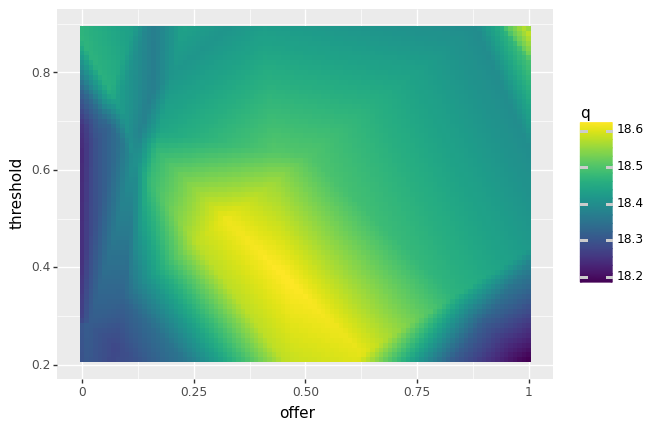

<ggplot: (-9223363251308270760)>

In [203]:
pn.ggplot(q_sliced, pn.aes(x='offer', y='threshold', fill='q')) + pn.geom_tile() #+ pn.scale_y_continuous(limits=(0.2, 0.8))

In [189]:
qlow = 18.2
qhi = 18.7

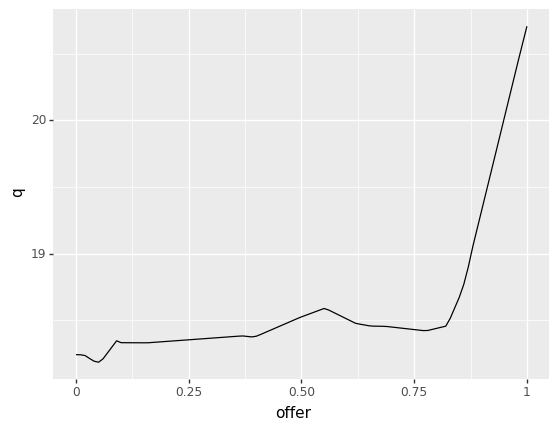

<ggplot: (-9223363251398146798)>

In [207]:
pn.ggplot(q[q.threshold==0.], pn.aes(x='offer', y='q')) + pn.geom_line()

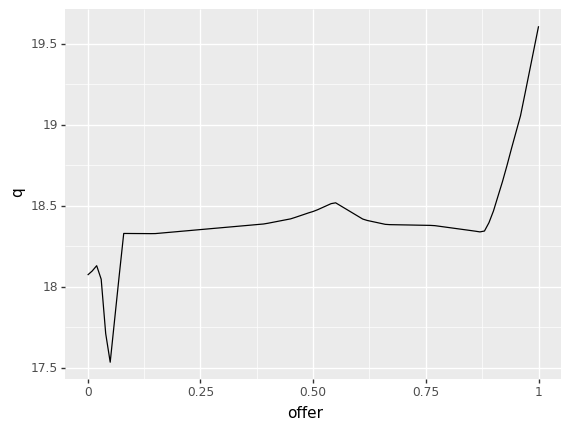

<ggplot: (8785547792353)>

In [208]:
pn.ggplot(q[q.threshold==0.01], pn.aes(x='offer', y='q')) + pn.geom_line()

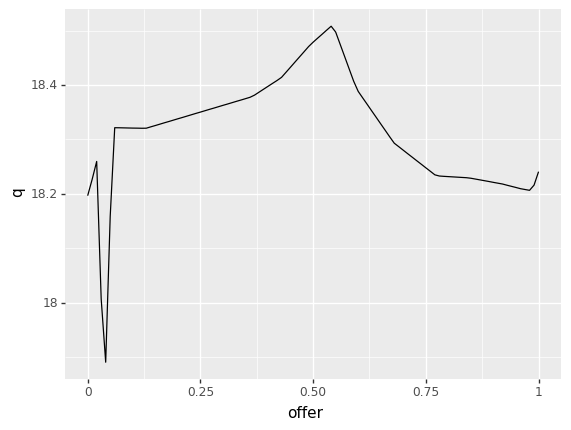

<ggplot: (8785456716029)>

In [211]:
pn.ggplot(q[q.threshold==0.03], pn.aes(x='offer', y='q')) + pn.geom_line()

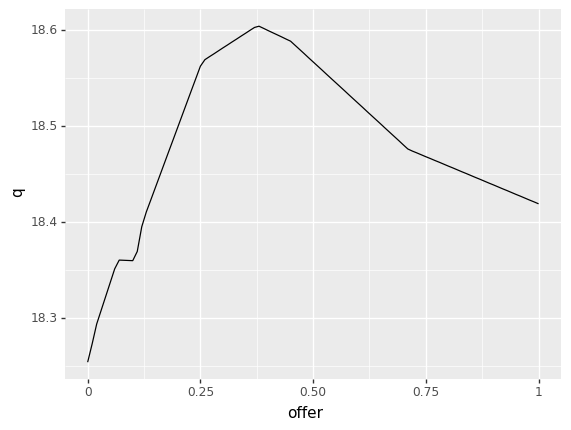

<ggplot: (8785456719578)>

In [184]:
pn.ggplot(q[q.threshold==0.45], pn.aes(x='offer', y='q')) + pn.geom_line()

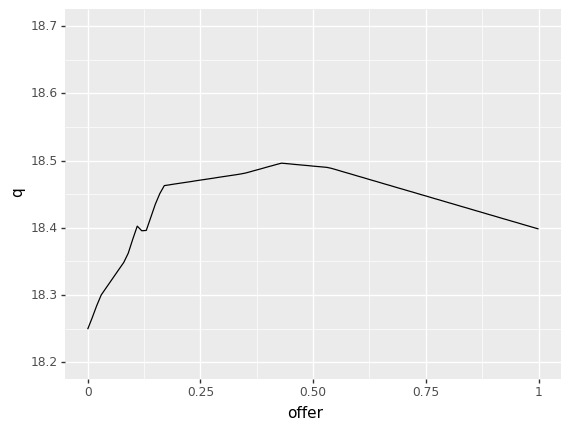

<ggplot: (-9223363251346993099)>

In [192]:
pn.ggplot(q[q.threshold==0.65], pn.aes(x='offer', y='q')) + pn.geom_line() + pn.scale_y_continuous(limits=(qlow, qhi))

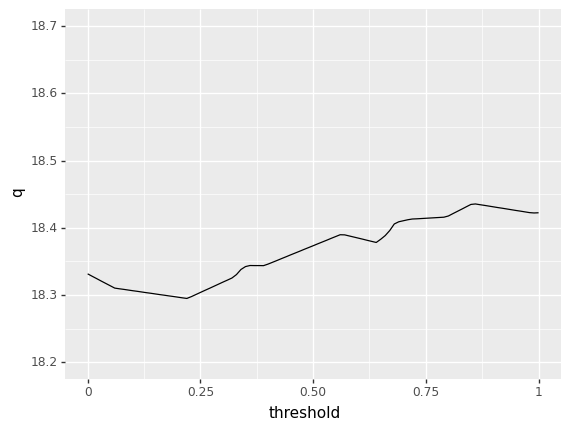

<ggplot: (-9223363251307887328)>

In [195]:
pn.ggplot(q[q.offer==0.1], pn.aes(x='threshold', y='q')) + pn.geom_line() + pn.scale_y_continuous(limits=(qlow, qhi))

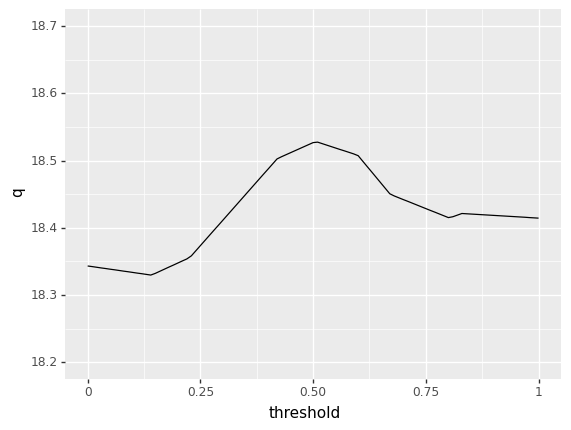

<ggplot: (8785547810999)>

In [191]:
pn.ggplot(q[q.offer==0.21], pn.aes(x='threshold', y='q')) + pn.geom_line() + pn.scale_y_continuous(limits=(qlow, qhi))

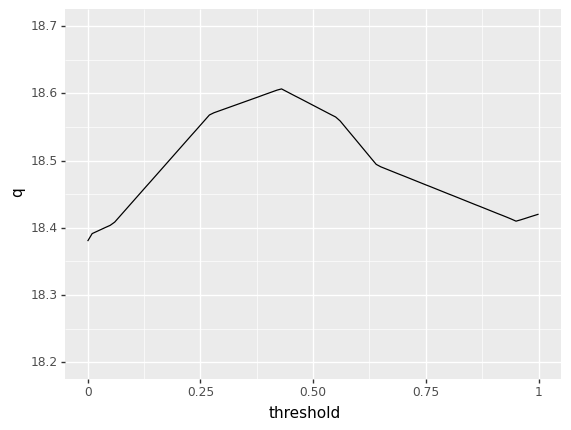

<ggplot: (8785546888631)>

In [193]:
pn.ggplot(q[q.offer==0.4], pn.aes(x='threshold', y='q')) + pn.geom_line() + pn.scale_y_continuous(limits=(qlow, qhi))

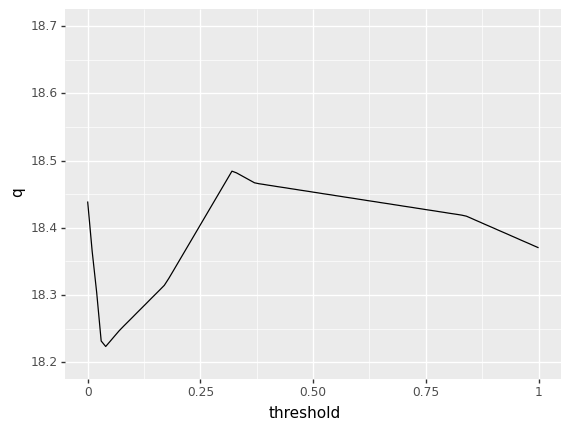

<ggplot: (8785507786013)>

In [190]:
pn.ggplot(q[q.offer==0.8], pn.aes(x='threshold', y='q')) + pn.geom_line() + pn.scale_y_continuous(limits=(qlow, qhi))